In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib
import mpltern

import pandas as pd
from bayesopt.bayesian_optimizer import BayesianOptimizer
from bayesopt import acquisitions
from bayesopt import model
from bayesopt import utils as ut
from bayesopt import metrics as boptmets

In [44]:
def run_bo_campaign(oracle, internal_model, acq, init_data, testable_points, y_true, n_its = 200, acq_kwargs = {'xi':0.25}, method = 'max'):
    # 1. run bayesian optimizer
    bopt = BayesianOptimizer(oracle, acq, internal_model, init_data, method = method, valid_points = testable_points, acq_kwargs = acq_kwargs)
    results = bopt.optimization_campaign(n_iterations = n_its)
    #2. process bopt results: get metrics
    bo_loss = [entry['oracleresult'][0] for entry in list(results.values())]
    queried_points = [entry['querypts'][0] for entry in list(results.values())]
    queried_points = np.stack(queried_points)
    #3. run a random campaign
    rng = np.random.default_rng()
    randinds = rng.integers(0, len(testable_points), n_its)
    random_points = testable_points[randinds]
    y_random = oracle.predict(random_points)
    
    #4. process random results
    
    # metrics
    bo_tp = boptmets.top_percent_campaign(testable_points, y_true, queried_points)
    rand_tp = boptmets.top_percent_campaign(testable_points, y_true, random_points)
    ef = boptmets.enhancement_factor(testable_points, y_true, queried_points, random_points)
    acc_fact = boptmets.acceleration_factor(testable_points, y_true, queried_points, random_points)
    
    return {'bo_points':queried_points, 'bo_loss':bo_loss, 'rand_points':random_points, 'bo_toppercent':bo_tp, 'rand_toppercent':rand_tp, 'enhancement_factor':ef, 'acceleration_factor':acc_fact}
    


In [4]:
def ternary_countourplot(points, design_space_points, oracle_values, best_point, title, cbar = True):    

    fig = plt.figure()
    ax = plt.subplot(projection = 'ternary')

    ax = plt.subplot(projection = 'ternary')
    ax2 = ax.tricontourf(design_space_points[:,0], design_space_points[:,1], design_space_points[:,2], oracle_values)
    

    ax.set_tlabel('CsPbI')
    ax.set_llabel('MAPbI')
    ax.set_rlabel('FAPbI')

    ax.set_title(title)
    #ax.scatter(points[:,0], points[:,1], points[:,2], )
    for i, (xplot, yplot, zplot) in enumerate(zip(points[:,0], points[:,1], points[:,2])):
        ax.scatter(xplot, yplot, zplot, color = ut.lighten_color('gray', 1- i/len(points)))

    ax.grid()
    ax.scatter(best_pt[0], best_pt[1], best_pt[2], marker = '*', color = 'r')
    if cbar:
        plt.colorbar(ax2, ax = ax, label = 'Inverse Loss', pad = 0.2)
    return fig


## 1. Load data from source

In [5]:
perovskite_data = pd.read_csv('https://raw.githubusercontent.com/kiranvad/DOE/master/final_project_data/Perovskite_dataset.csv')

In [6]:
perovskite_data

,CsPbI,FAPbI,MAPbI,Instability index
0,0.00,1.00,0.00,480185
1,0.00,1.00,0.00,505657
2,0.25,0.75,0.00,144074
3,0.50,0.50,0.00,239852
4,0.50,0.50,0.00,416657
...,...,...,...,...
134,0.26,0.38,0.36,593083
135,0.00,0.00,1.00,1375402
136,0.00,0.00,1.00,1413800
137,0.00,0.00,1.00,1583406


## 2. Build an oracle model

In [7]:
X = perovskite_data[['CsPbI', 'MAPbI', 'FAPbI']].to_numpy()
y = perovskite_data['Instability index'].to_numpy()


scale = preprocessing.MinMaxScaler()
oraclemodel = RandomForestRegressor(n_estimators = 500)


y_scaled = preprocessing.MinMaxScaler().fit_transform(y.reshape(-1,1))
y_inv = 1 - y_scaled

X_train, X_test, y_train, y_test = train_test_split(X, y_inv, random_state = 42)


#oracle = GaussianProcessRegressor(kernel = 1.0*kernels.Matern())
estimator = Pipeline([('scaler', scale), ('estimator', oraclemodel)])
estimator.fit(X_train, y_train)



/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator', RandomForestRegressor(n_estimators=500))])

In [8]:
oracle = ut.Oracle(estimator, 0.025)

In [9]:
y_pred = estimator.predict(X_test)

In [10]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)


print('MAE: ', mae)
print('mape: ', mape)
print('mse: ', mse)
print('r2: ', r2)

MAE:  0.06312097516205767
mape:  0.11356752367301554
mse:  0.006272155781040978
r2:  0.861304190565622


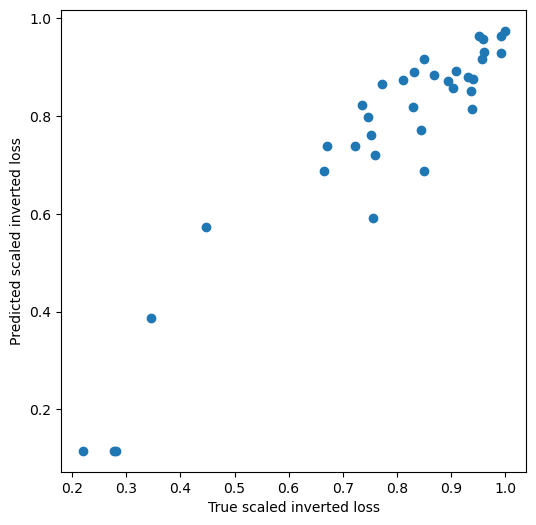

In [11]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(y_test, y_pred)
ax.set_xlabel('True scaled inverted loss')
ax.set_ylabel('Predicted scaled inverted loss')
plt.savefig('perovskites_parity.png', dpi = 300)

## 3. Sample initial points to seed BO

#### Define sample space of points we can sample from:

In [12]:
CsPbI = np.linspace(0, 1, 101)
FAPbI = np.linspace(0, 1, 101)
MAPbI = np.linspace(0,1, 101)


# do a brute force constrained sampling to get points in the design space
test_arr = np.array(np.meshgrid(CsPbI, MAPbI, FAPbI,)).T.reshape(-1,3)
indices = np.where(test_arr.sum(axis = 1) != 1)[0]
testable_points = np.delete(test_arr, indices, axis = 0)

In [13]:
# random sample some points as initial data
rng = np.random.default_rng(seed = 4)
selected_inds = rng.integers(0, len(testable_points), 15)
selected_points = testable_points[selected_inds, :]
y_init = oracle.predict(selected_points)

In [14]:
len(testable_points)

5027

## 4. Run BO campaigns

#### a. Expected Improvement

In [42]:
kernel = kernels.Matern(nu=1/2)
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 1e-5)
acq = acquisitions.optimize_EI
init_data = (selected_points, y_init)

y_true = oracle.predict(testable_points)
best_pt = testable_points[np.argmax(y_true)]

In [45]:
EI_results = run_bo_campaign(oracle, internal_model, acq, init_data, testable_points, y_true, n_its = 200, acq_kwargs = {'xi':0.25})

/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: divide by zero encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)
/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


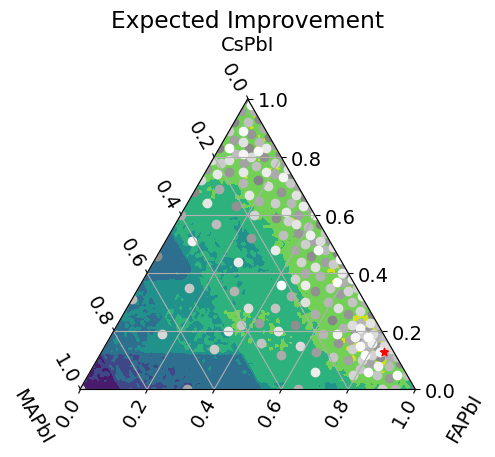

In [46]:
#5. generate plots
ax = ternary_countourplot(EI_results['bo_points'], testable_points, y_true, best_pt, 'Expected Improvement', cbar = False)

plt.tight_layout()
plt.savefig('perovskite_EI.png', dpi = 300)


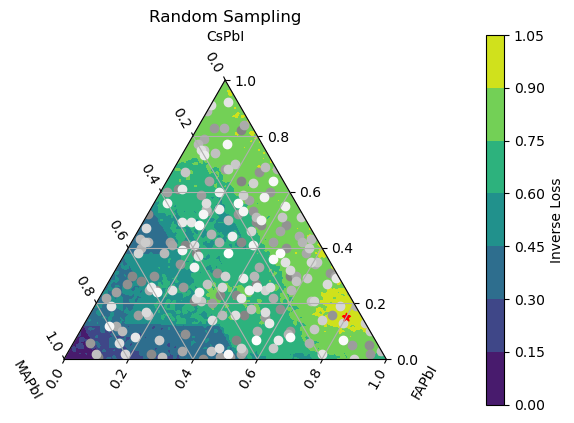

In [18]:
ax  = ternary_countourplot(EI_results['rand_points'], testable_points, y_true, best_pt, 'Random Sampling')

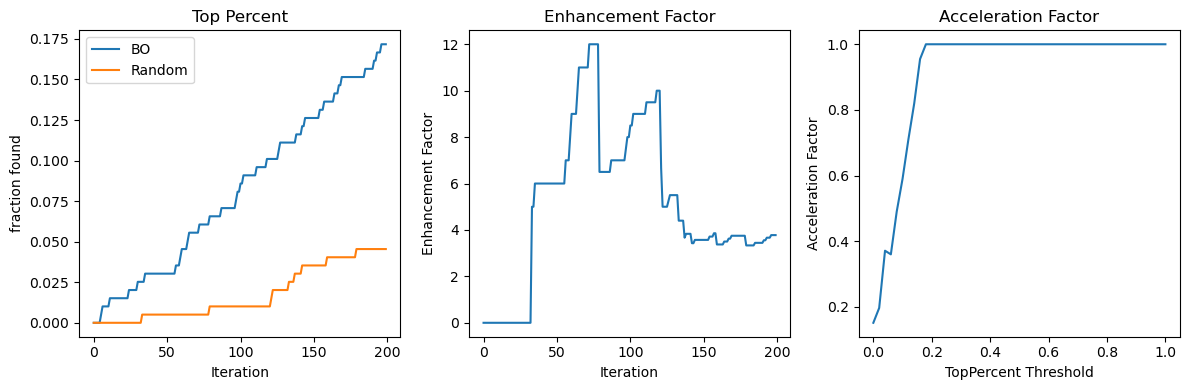

In [19]:
fig, ax = plt.subplots(1,3, figsize = (12, 4))

ax[0].plot(EI_results['bo_toppercent'], label = 'BO')
ax[0].plot(EI_results['rand_toppercent'], label = 'Random')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('fraction found')
ax[0].set_title('Top Percent')
ax[0].legend()

ax[1].plot(EI_results['enhancement_factor'])
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Enhancement Factor')
ax[1].set_title('Enhancement Factor')

ax[2].plot(EI_results['acceleration_factor'][0], EI_results['acceleration_factor'][1])
ax[2].set_xlabel('TopPercent Threshold')
ax[2].set_ylabel('Acceleration Factor')
ax[2].set_title('Acceleration Factor')

plt.tight_layout()

In [48]:
EI_results['bo_points'][np.argmax(EI_results['bo_loss'])]

array([0.13, 0.  , 0.87])

#### b. Upper Confidence Bound

In [20]:
kernel = kernels.Matern(nu=1/2)
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 1e-5)
acq = acquisitions.optimize_UCB
init_data = (selected_points, y_init)

y_true = oracle.predict(testable_points)
best_pt = testable_points[np.argmax(y_true)]

In [21]:
UCB_results = run_bo_campaign(oracle, internal_model, acq, init_data, testable_points, y_true, n_its = 200, acq_kwargs = {'beta':1})

/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: divide by zero encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)
/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


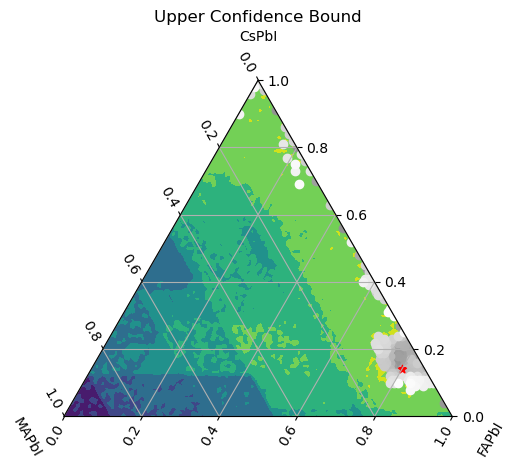

In [22]:
ax = ternary_countourplot(UCB_results['bo_points'], testable_points, y_true, best_pt, 'Upper Confidence Bound', cbar = False)
plt.tight_layout()
plt.savefig('perovskite_UCB.png', dpi = 300)

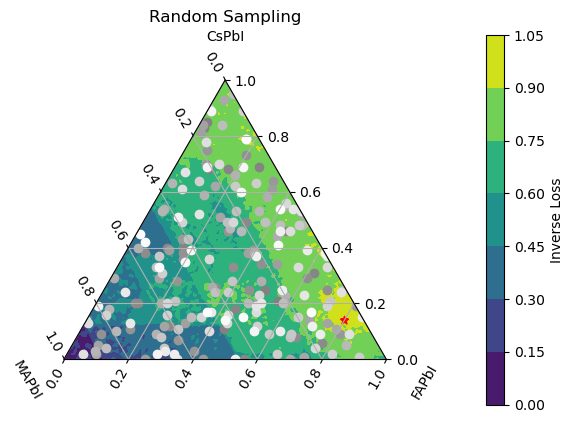

In [23]:
ax  = ternary_countourplot(UCB_results['rand_points'], testable_points, y_true, best_pt, 'Random Sampling')

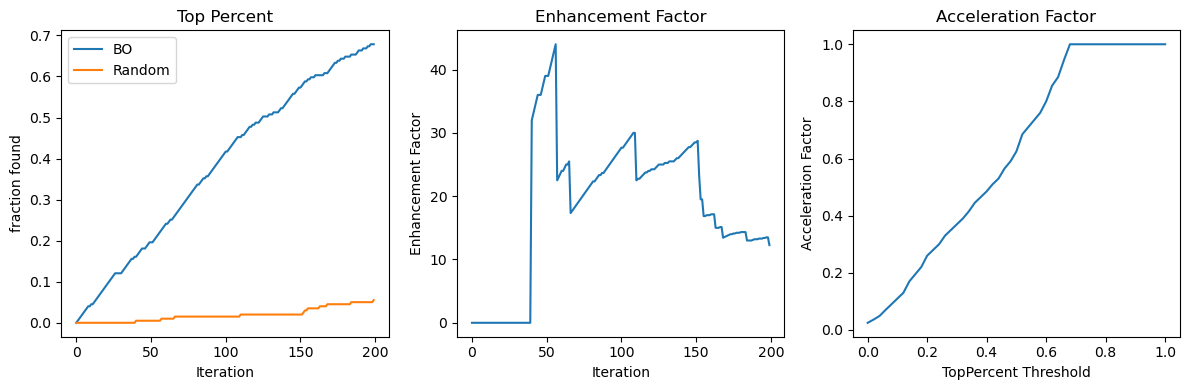

In [24]:
fig, ax = plt.subplots(1,3, figsize = (12, 4))

ax[0].plot(UCB_results['bo_toppercent'], label = 'BO')
ax[0].plot(UCB_results['rand_toppercent'], label = 'Random')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('fraction found')
ax[0].set_title('Top Percent')
ax[0].legend()

ax[1].plot(UCB_results['enhancement_factor'])
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Enhancement Factor')
ax[1].set_title('Enhancement Factor')

ax[2].plot(UCB_results['acceleration_factor'][0], UCB_results['acceleration_factor'][1])
ax[2].set_xlabel('TopPercent Threshold')
ax[2].set_ylabel('Acceleration Factor')
ax[2].set_title('Acceleration Factor')

plt.tight_layout()

#### c. Probability of Improvement

In [25]:
kernel = kernels.Matern(nu=1/2)
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 1e-5)
acq = acquisitions.optimize_PI
init_data = (selected_points, y_init)

y_true = oracle.predict(testable_points)
best_pt = testable_points[np.argmax(y_true)]

In [26]:
PI_results = run_bo_campaign(oracle, internal_model, acq, init_data, testable_points, y_true, n_its = 200, acq_kwargs = {'xi':0.25})

/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: divide by zero encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)
/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


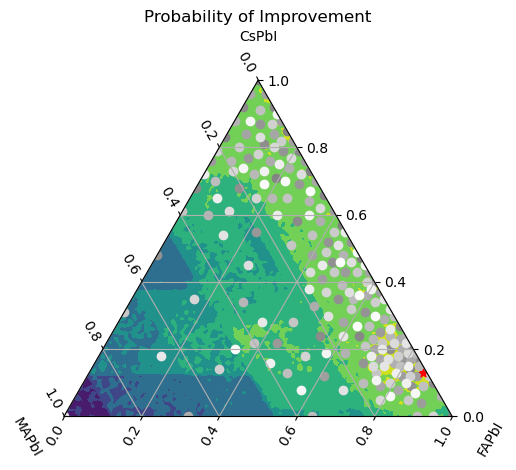

In [27]:
ax = ternary_countourplot(PI_results['bo_points'], testable_points, y_true, best_pt, 'Probability of Improvement', cbar = False)
plt.tight_layout()
plt.savefig('perovskite_PI.png', dpi = 300)

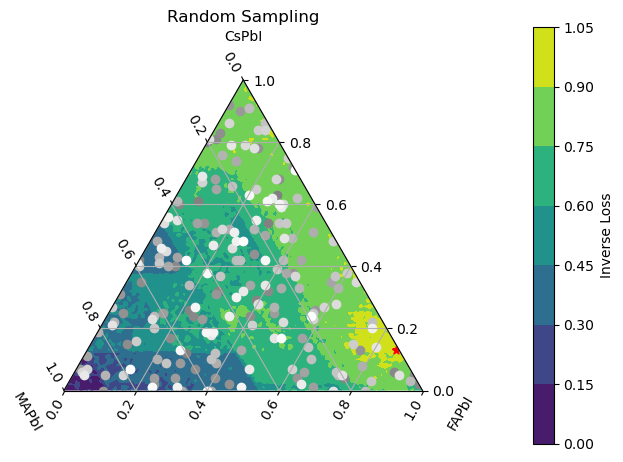

In [28]:
ax  = ternary_countourplot(PI_results['rand_points'], testable_points, y_true, best_pt, 'Random Sampling')
plt.tight_layout()
plt.savefig('perovskite_rand.png', dpi = 300)

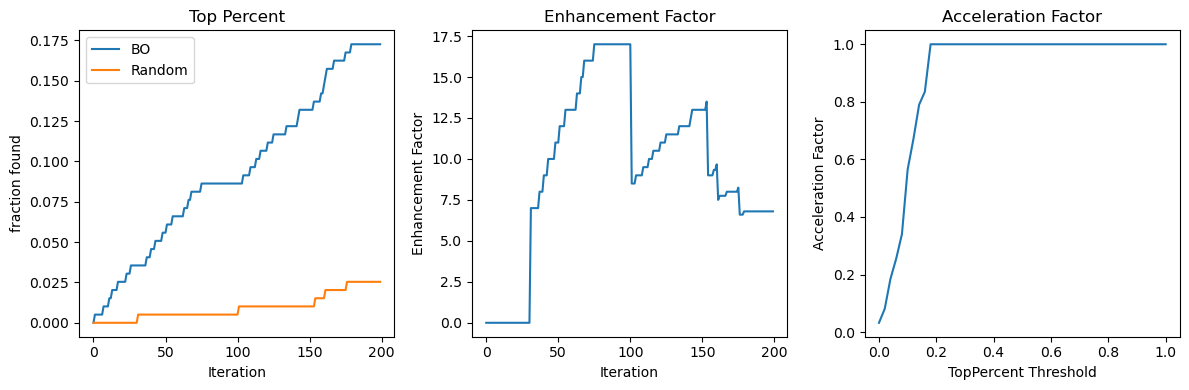

In [29]:
fig, ax = plt.subplots(1,3, figsize = (12, 4))

ax[0].plot(PI_results['bo_toppercent'], label = 'BO')
ax[0].plot(PI_results['rand_toppercent'], label = 'Random')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('fraction found')
ax[0].set_title('Top Percent')
ax[0].legend()

ax[1].plot(PI_results['enhancement_factor'])
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Enhancement Factor')
ax[1].set_title('Enhancement Factor')

ax[2].plot(PI_results['acceleration_factor'][0], PI_results['acceleration_factor'][1])
ax[2].set_xlabel('TopPercent Threshold')
ax[2].set_ylabel('Acceleration Factor')
ax[2].set_title('Acceleration Factor')

plt.tight_layout()

## Composite plots

#### Top percent for each acq:

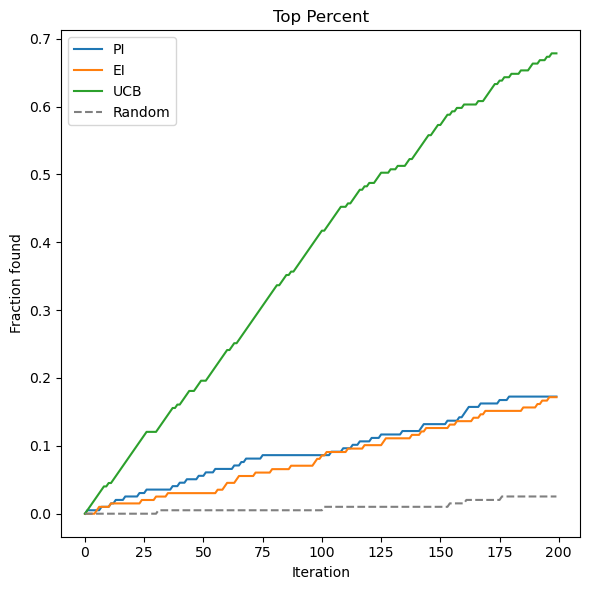

In [30]:
fig, ax = plt.subplots(figsize = (6,6))

ax.plot(PI_results['bo_toppercent'], label = 'PI')
ax.plot(EI_results['bo_toppercent'], label = 'EI')
ax.plot(UCB_results['bo_toppercent'], label = 'UCB')
ax.plot(PI_results['rand_toppercent'], label = 'Random', color = 'gray', ls = '--')

ax.set_xlabel('Iteration')
ax.set_ylabel('Fraction found')
ax.set_title('Top Percent')
ax.legend()
ax.set_title('Top Percent')
plt.tight_layout()

plt.savefig('perovskite_acq_sweep.png', dpi = 300)

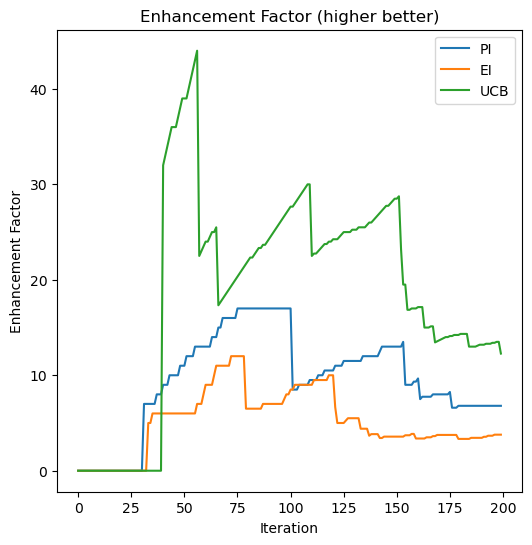

In [31]:
fig, ax = plt.subplots(figsize = (6,6))

ax.plot(PI_results['enhancement_factor'], label = 'PI')
ax.plot(EI_results['enhancement_factor'], label = 'EI')
ax.plot(UCB_results['enhancement_factor'], label = 'UCB')
ax.set_title('Enhancement Factor (higher better)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Enhancement Factor')
ax.legend()

plt.savefig('perovskite_enhancement_factor.png', dpi = 300)

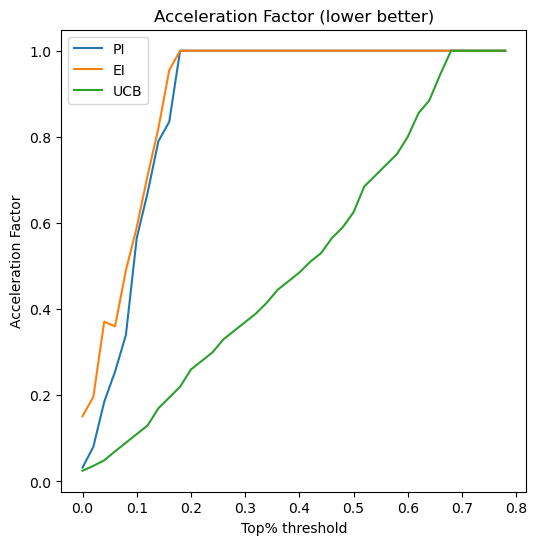

In [32]:
fig, ax = plt.subplots(figsize = (6,6))

stop = 40

ax.plot(PI_results['acceleration_factor'][0][0:stop], PI_results['acceleration_factor'][1][0:stop], label = 'PI')
ax.plot(EI_results['acceleration_factor'][0][0:stop], EI_results['acceleration_factor'][1][0:stop], label = 'EI')
ax.plot(UCB_results['acceleration_factor'][0][0:stop], UCB_results['acceleration_factor'][1][0:stop], label = 'UCB')
ax.set_title('Acceleration Factor (lower better)')
ax.set_xlabel('Top% threshold')
ax.set_ylabel('Acceleration Factor')
ax.legend()

plt.savefig('perovskite_acceleration_factor.png', dpi = 300)

### Explore/Exploit tradeoff

#### 1. xi = 0

In [33]:
kernel = kernels.Matern(nu=1/2)
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 1e-5)
acq = acquisitions.optimize_PI
init_data = (selected_points, y_init)

y_true = oracle.predict(testable_points)
best_pt = testable_points[np.argmax(y_true)]

xi0_results = run_bo_campaign(oracle, internal_model, acq, init_data, testable_points, y_true, n_its = 200, acq_kwargs = {'xi':0})

/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: divide by zero encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)
/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


#### 2. Xi = 1

In [34]:
kernel = kernels.Matern(nu=1/2)
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 1e-5)
acq = acquisitions.optimize_PI
init_data = (selected_points, y_init)

y_true = oracle.predict(testable_points)
best_pt = testable_points[np.argmax(y_true)]

xi025_results = run_bo_campaign(oracle, internal_model, acq, init_data, testable_points, y_true, n_its = 200, acq_kwargs = {'xi':0.25})

/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: divide by zero encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)
/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


#### 3. Xi = 10

In [35]:
kernel = kernels.Matern(nu=1/2)
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 1e-5)
acq = acquisitions.optimize_PI
init_data = (selected_points, y_init)

y_true = oracle.predict(testable_points)
best_pt = testable_points[np.argmax(y_true)]

xi1_results = run_bo_campaign(oracle, internal_model, acq, init_data, testable_points, y_true, n_its = 200, acq_kwargs = {'xi':1})

/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: divide by zero encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)
/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


In [36]:
font = {'size':14}
matplotlib.rc('font', **font)

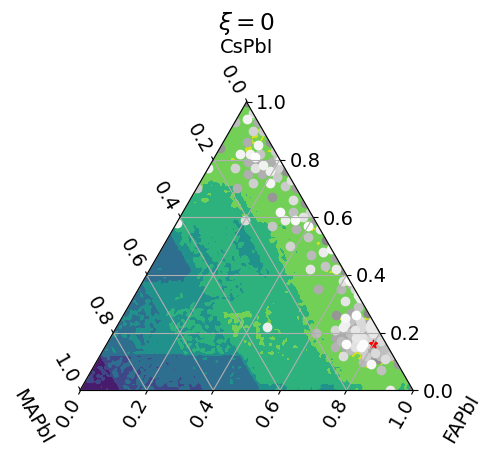

In [37]:
ax = ternary_countourplot(xi0_results['bo_points'], testable_points, y_true, best_pt, r'$\xi = 0$', cbar = False)
plt.tight_layout()
plt.savefig('perovskites_xi0.png', dpi = 300)

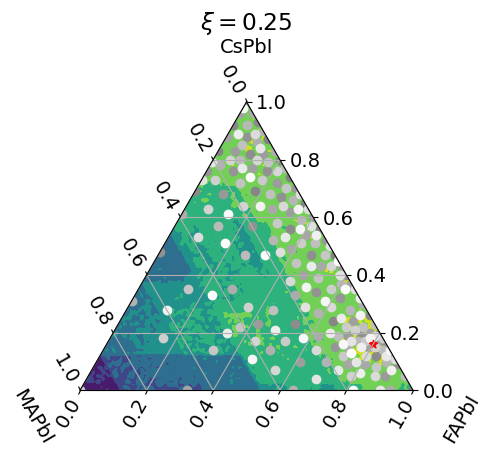

In [38]:
ax = ternary_countourplot(xi025_results['bo_points'], testable_points, y_true, best_pt, r'$\xi = 0.25$', cbar = False)
plt.tight_layout()
plt.savefig('perovskites_xi25.png', dpi = 300)

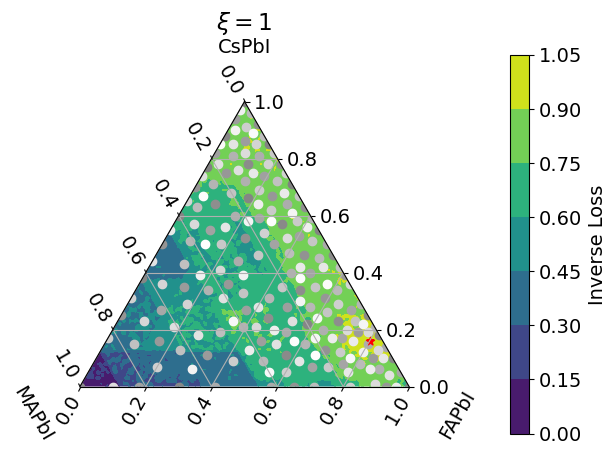

In [39]:
ax = ternary_countourplot(xi1_results['bo_points'], testable_points, y_true, best_pt, r'$\xi = 1$', cbar = True)
plt.tight_layout()
plt.savefig('perovskites_xi1.png', dpi = 300)

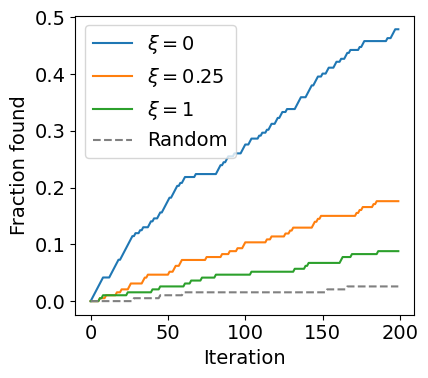

In [40]:
fig, ax = plt.subplots(figsize = (4.5,4))

ax.plot(xi0_results['bo_toppercent'], label = r'$\xi = 0$')
ax.plot(xi025_results['bo_toppercent'], label = r'$\xi = 0.25$')
ax.plot(xi1_results['bo_toppercent'], label = r'$\xi = 1$')
ax.plot(xi1_results['rand_toppercent'], label = 'Random', color = 'gray', ls = '--')

ax.set_xlabel('Iteration')
ax.set_ylabel('Fraction found')
ax.legend()
plt.tight_layout()

plt.savefig('perovskite_xiparamsweep.png', dpi = 300)